In [1]:
import xlrd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Alphabet import IUPAC
import numpy as np
import pandas as pd
import os

!wget https://science.sciencemag.org/highwire/filestream/690833/field_highwire_adjunct_files/2/aai7825_Leuenberger_Table-S3.xlsx 
!mv aai7825_Leuenberger_Table-S3.xlsx ../data/

### Load data

In [3]:
wb = xlrd.open_workbook('../data/aai7825_Leuenberger_Table-S3.xlsx')

In [4]:
seqs, tms, orgs = {},{},{}
for name in ['E. coli','T. thermophilus','S. cerevisiae']:
    sh = wb.sheet_by_name(name)
    for i in range(sh.ncols): 
        if sh.cell(0,i).value == 'Tm Protein': tm_col = i
        if sh.cell(0,i).value == 'Sequence': seq_col = i
        if sh.cell(0,i).value == 'Protein_ID': id_col = i
    
    for j in range(sh.nrows-1):
        j += 1
        prot_id = sh.cell(j,id_col).value.split(';')[0]
        seqs[prot_id] = sh.cell(j,seq_col).value
        tms[prot_id] = sh.cell(j,tm_col).value
        orgs[prot_id] = name.replace(' ','')
print(len(seqs))

2517


### Clean data

In [5]:
def is_valid_seq(seq, max_len=2000,min_len=31):
    """
    True if seq is valid, False otherwise.
    """
    l = len(seq)
    valid_aas = "ACDEFGHIKLMNPQRSTVWY"
    if (l <= max_len) and set(seq) <= set(valid_aas) and l>=min_len: return True
    else: return False

In [6]:
valid_seqs = []
for seq_id in seqs.keys():
    if is_valid_seq(seqs[seq_id]): valid_seqs.append(seq_id)
print(len(valid_seqs))

2506


### Save to fasta

In [8]:
fhand = open('../data/cleaned_enzyme_tms_v1.fasta','w')
all_recs = list()
for seq_id in valid_seqs:
    record = SeqRecord(Seq(seqs[seq_id],IUPAC.protein),id=seq_id, name="",
                       description="{0} {1}".format(orgs[seq_id],tms[seq_id]))
    all_recs.append(record)
SeqIO.write(all_recs,fhand,'fasta')
fhand.close()

In [9]:
!head ../data/cleaned_enzyme_tms_v1.fasta

>P00350 E.coli 57.82613507
MSKQQIGVVGMAVMGRNLALNIESRGYTVSIFNRSREKTEEVIAENPGKKLVPYYTVKEF
VESLETPRRILLMVKAGAGTDAAIDSLKPYLDKGDIIIDGGNTFFQDTIRRNRELSAEGF
NFIGTGVSGGEEGALKGPSIMPGGQKEAYELVAPILTKIAAVAEDGEPCVTYIGADGAGH
YVKMVHNGIEYGDMQLIAEAYSLLKGGLNLTNEELAQTFTEWNNGELSSYLIDITKDIFT
KKDEDGNYLVDVILDEAANKGTGKWTSQSALDLGEPLSLITESVFARYISSLKDQRVAAS
KVLSGPQAQPAGDKAEFIEKVRRALYLGKIVSYAQGFSQLRAASEEYNWDLNYGEIAKIF
RAGCIIRAQFLQKITDAYAENPQIANLLLAPYFKQIADDYQQALRDVVAYAVQNGIPVPT
FSAAVAYYDSYRAAVLPANLIQAQRDYFGAHTYKRIDKEGVFHTEWLD
>P00363 E.coli 46.76964303


### Split dataset into train, test

In [16]:
def split_datasets(input_fasta,split=0.9):
    # input_fasta is a fasta file with topts and ogts of all enzymes
    # 
    
    # 1. remove those enzymes longer than 2000 residues
    recs = [rec for rec in SeqIO.parse(input_fasta,'fasta') if len(rec.seq)<=2000]
    print('Number of sequnces:', len(recs))
    print('ori',[recs[i].id for i in range(5)])
    recs = np.array(recs)
    
    # 2. random split it into train and test
    np.random.seed(212)
    shuffled_index = np.arange(len(recs))
    np.random.shuffle(shuffled_index)
    np.random.seed()
    print(shuffled_index)
    recs = recs[shuffled_index]
    print('shuffuled',[recs[i].id for i in range(5)])
    split_point = int(split*len(recs))
    training_seqs = recs[:split_point]
    test_seqs     = recs[split_point:]
    
    print('Number of training seqs',len(training_seqs))
    print('Number of test seqs',len(test_seqs))
    
    # save fasta files
    trainfile = input_fasta.replace('.fasta','')+'_train.fasta'
    testfile = input_fasta.replace('.fasta','')+'_test.fasta'
    
    ftrain = open(trainfile,'w')
    ftest = open(testfile,'w')
    
    SeqIO.write(training_seqs,ftrain,'fasta')
    SeqIO.write(test_seqs,ftest,'fasta')
    
    ftrain.close()
    ftest.close()

split_datasets('../data/cleaned_enzyme_tms_v1.fasta',split=0.9)

In [18]:
!head ../data/cleaned_enzyme_tms_v1_test.fasta

>P22515 S.cerevisiae 45.43043484
MSSNNSGLSAAGEIDESLYSRQLYVLGKEAMLKMQTSNVLILGLKGLGVEIAKNVVLAGV
KSMTVFDPEPVQLADLSTQFFLTEKDIGQKRGDVTRAKLAELNAYVPVNVLDSLDDVTQL
SQFQVVVATDTVSLEDKVKINEFCHSSGIRFISSETRGLFGNTFVDLGDEFTVLDPTGEE
PRTGMVSDIEPDGTVTMLDDNRHGLEDGNFVRFSEVEGLDKLNDGTLFKVEVLGPFAFRI
GSVKEYGEYKKGGIFTEVKVPRKISFKSLKQQLSNPEFVFSDFAKFDRAAQLHLGFQALH
QFAVRHNGELPRTMNDEDANELIKLVTDLSVQQPEVLGEGVDVNEDLIKELSYQARGDIP
GVVAFFGGLVAQEVLKACSGKFTPLKQFMYFDSLESLPDPKNFPRNEKTTQPVNSRYDNQ
IAVFGLDFQKKIANSKVFLVGSGAIGCEMLKNWALLGLGSGSDGYIVVTDNDSIEKSNLN
RQFLFRPKDVGKNKSEVAAEAVCAMNPDLKGKINAKIDKVGPETEEIFNDSFWESLDFVT


In [11]:
from matplotlib import pyplot as plt

In [19]:
def plot_tm(fasta):
    tms = [float(line.split()[-1]) for line in open(fasta) if line.startswith('>')]
    plt.figure(figsize=(3,2.5))
    plt.hist(tms,50)
    plt.xlabel('$T_m$ ($^\circ$C)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

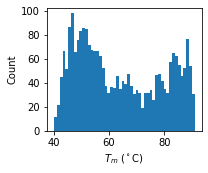

In [20]:
plot_tm('../data/cleaned_enzyme_tms_v1.fasta')

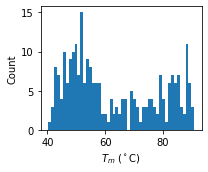

In [21]:
plot_tm('../data/cleaned_enzyme_tms_v1_test.fasta')

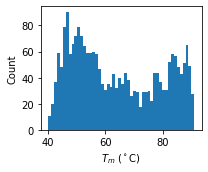

In [22]:
plot_tm('../data/cleaned_enzyme_tms_v1_train.fasta')

### iFeatures

In [32]:
def merge_iFeatures():
    indir = 'Extracted_iFeatures_Tm/'
    dfall = None
    for name in os.listdir(indir):
        df = pd.read_csv(os.path.join(indir,name),sep='\t',index_col=0)
        if dfall is None: dfall = df.copy()
        else: dfall = pd.merge(dfall,df,left_index=True,right_index=True,how='inner')
    print(dfall.shape)
    
    tms = {rec.id:float(rec.description.split()[-1]) for rec in SeqIO.parse('../data/cleaned_enzyme_tms_v1.fasta','fasta')}
    dfall['tm'] = [tms[ind] for ind in dfall.index]
    print(dfall.shape)
    dfall.to_csv('../data/tm_iFeatures.csv')
    print(dfall.head(5))

In [33]:
merge_iFeatures()

(2506, 5494)
(2506, 5495)
               A         C         D         E         F         G         H  \
#                                                                              
P00350  0.108974  0.004274  0.057692  0.072650  0.036325  0.087607  0.008547   
P00363  0.101329  0.016611  0.058140  0.073090  0.033223  0.109635  0.034884   
P00370  0.105145  0.008949  0.042506  0.069351  0.049217  0.109620  0.022371   
P00448  0.126214  0.000000  0.058252  0.063107  0.053398  0.063107  0.038835   
P00452  0.081472  0.014455  0.067017  0.060447  0.036794  0.063075  0.026281   

               I         K         L    ...      Xc2.lambda22  Xc2.lambda23  \
#                                       ...                                   
P00350  0.074786  0.059829  0.085470    ...          0.023289      0.023783   
P00363  0.038206  0.044850  0.079734    ...          0.025674      0.024527   
P00370  0.038031  0.049217  0.078300    ...          0.025230      0.024877   
P00448  0.029126  

### UniRep

In [6]:
def unirep_feature():
    dfall = pd.read_csv('../data/cleaned_enzyme_tms_v1.fasta_unirep.csv',index_col=0)
    tms = {rec.id:float(rec.description.split()[-1]) for rec in SeqIO.parse('../data/cleaned_enzyme_tms_v1.fasta','fasta')}
    dfall['tm'] = [tms[ind] for ind in dfall.index]
    print(dfall.shape)
    dfall.to_csv('../data/tm_unirep.csv')
    print(dfall.head(5))

In [7]:
unirep_feature()

(2506, 5701)
            av_1      av_2      av_3      av_4      av_5      av_6      av_7  \
P00350  0.023348  0.103948  0.115232 -0.046291 -0.031405  0.035689  0.091538   
P00363  0.018047  0.110836  0.056840 -0.020883 -0.242539  0.116526  0.040931   
P00370  0.005392  0.121998  0.118537 -0.034731 -0.146919  0.104927 -0.011717   
P00448  0.003352 -0.011320  0.053151 -0.013149 -0.050491  0.056789 -0.077834   
P00452  0.002944  0.020775  0.071420 -0.027629  0.314275  0.039193  0.100978   

            av_8      av_9     av_10    ...       fc_1892   fc_1893  \
P00350 -0.037810 -0.004953  0.096587    ...      1.365720 -2.618035   
P00363  0.008316 -0.003512  0.028626    ...      0.555636 -8.387062   
P00370 -0.022139 -0.005157  0.016173    ...      0.245512 -0.754901   
P00448 -0.017443 -0.007220  0.025634    ...      1.135081  0.348549   
P00452 -0.012032 -0.002950 -0.031175    ...      0.063986 -4.467035   

          fc_1894   fc_1895   fc_1896   fc_1897   fc_1898   fc_1899   fc_1900  